In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
#imports for problem 2
import matplotlib.pyplot as plt 
from PIL import Image
import json
from mpl_toolkits.axes_grid1 import ImageGrid

#imports for problem 3
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#imports for problem 4
import torch.nn as nn
import torch.optim as optim


## Problem 4: Training a Small CNN

### Part 1


#### Model architecture, training, and testing

Train a CNN with 3 hidden convolutional layers that use the Mish activation function. 
Layer 1: (32 x 7 × 7) filters & (2 × 2) max pooling (stride of 2). 
Layer 2 and 3: (64 x 3 × 3) filters &  Mish activation function. 

Avg pooling layer + Softmax layer

Prior to the softmax layer, you should have an average pooling layer that pools across the preceding feature map. Optimizer: AdamW, Ranger, RAdam
 
Tune your hyperparameters on a small version of the dataset to make sure your training loss goes down and things are set up correctly.
Train your model using all of the CIFAR-10 training data, and evaluate your trained system on the CIFAR-10 test data.

In [2]:
#load the CIFAR-10 dataset
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)
print(f'- Trainset size: {len(train)}')
print(f'- Testset size: {len(test)}')
print(f'- Number of classes: {len(train.classes)}')
print(f'- Classes: {train.classes}')
print(f'- Images shape: {train[0][0].shape}')

100%|██████████| 170498071/170498071 [00:12<00:00, 13139901.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
- Trainset size: 50000
- Testset size: 10000
- Number of classes: 10
- Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
- Images shape: torch.Size([3, 32, 32])


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(64, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)
        self.mish = nn.Mish()
        
    def forward(self, x):
        x = self.pool(self.mish(self.conv1(x)))
        x = self.mish(self.conv2(x))
        x = self.mish(self.conv3(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.functional.softmax(x, dim=1)
        return x

In [8]:
#reused code from MNIST and CIFAR Tutorial
def train(epoch):
    model.train()
    train_losses = []
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target) #nn.functional.nll_loss(output, target)
        loss.backward()
        torch.cuda.empty_cache() #release gpu memory
        optimizer.step()
        #print loss
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item())
                )
        train_losses.append(loss.item() / batch_size)
    return train_losses

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        test_loss += loss_fn(output, target).sum()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).long().cpu().sum()
    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, 
        len(testloader.dataset),
        100. * (correct / len(testloader.dataset))))
    return test_loss

model = Net()
model.cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

train_losses, test_losses = [], []
num_epochs = 30
print(f'Training for {num_epochs} epochs')
for epoch in range(1, num_epochs + 1):
    #train and compute train loss
    epoch_train_losses = train(epoch)
    train_losses.append(torch.tensor(epoch_train_losses).mean().item())
    test_loss = test()
    test_losses.append(test_loss.item())


Training for 30 epochs
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303033
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.145427
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.095390
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.102294

Test set: Average loss: 0.0163, Accuracy: 3971/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.088928
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.069380
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.059103
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.021033

Test set: Average loss: 0.0159, Accuracy: 4486/10000 (45%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.086636
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.982945
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.968972
Train Epoch: 3 [38400/50000 (77%)]	Loss: 2.027112

Test set: Average loss: 0.0156, Accuracy: 4928/10000 (49%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.012789
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.937002
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.963972
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.912017

Test set: Ave

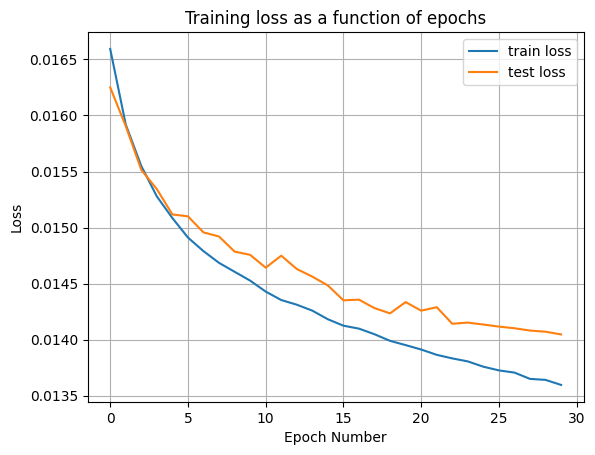

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()
plt.title('Training loss as a function of epochs')
plt.legend(['train loss', 'test loss'])

#### Filters visualization

Visualize all of the 7×7×3 filters learned by the first convolutional layer as an RGB image array (I suggest making a large RGB image that is made up of each of the smaller images). This visualization of the filters should be similar to the ones we saw in class. Note that you will need to normalize each filter to display them.


torch.Size([32, 3, 7, 7])


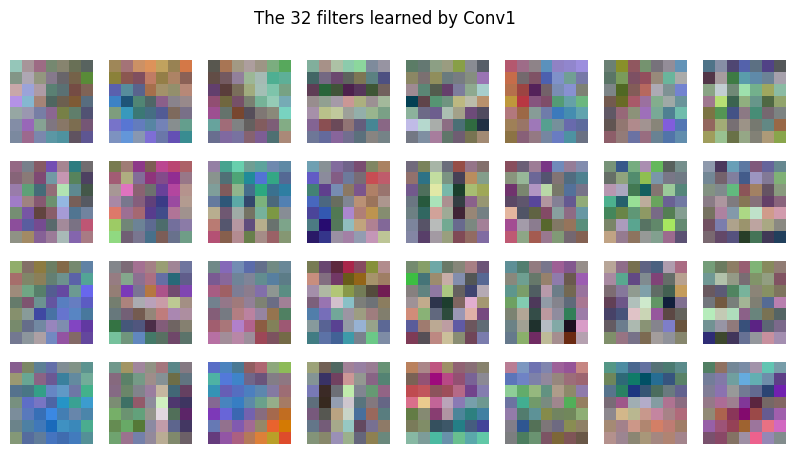

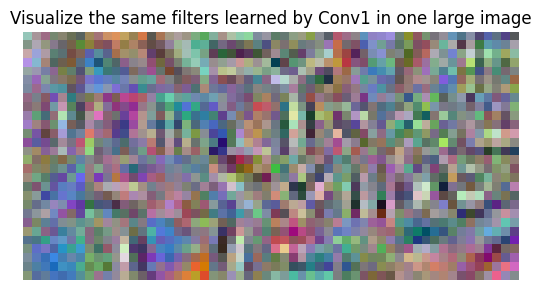

In [ ]:
#retrieve filters from conv1
filters = model.conv1.weight.data
print(filters.shape)
num_filters, filter_size = filters.size(0), filters.size(2)

#normalize filters
eps = 0.0001
filter_dist = torch.norm(filters, p=float('inf')) #torch.linalg.norm(filters, ord = 'inf') #max(sum(abs(filters), dim=1))
filters_norm = (filters / (2 * filter_dist + eps)) + (1/2)
filters_arr = np.transpose(filters_norm.cpu(), (0, 2, 3, 1))

num_cols, num_rows = 8, 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))
fig.suptitle('The 32 filters learned by Conv1')
for i in range(num_filters):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(filters_arr[i])
    axs[row, col].axis('off')
plt.show()

#one large image
image = np.zeros((num_rows * filter_size, num_cols * filter_size, 3))
#fill image array with normalized filters
for i in range(num_filters):
    row = i // num_cols
    col = i % num_cols
    image[row * filter_size: (row + 1) * filter_size, col * filter_size: (col + 1) * filter_size, :] = filters_arr[i].cpu()

#display image of filters
plt.imshow(image)
plt.axis('off')
plt.title('Visualize the same filters learned by Conv1 in one large image')
plt.show()

- What is the accuracy on the test data? 

The accuracy on the test data is 69%.

- How did you initialize the weights? 

I have initially used the default Pytorch weight initialization by not specifying the weights. However after using the Kaiming/He initialization method, the accuracy of the model has increased. This method initializes the weights with random values drawn from a Gaussian distribution with mean 0 and variance of the square root of the inverse of the number of the input. 

This post 'https://towardsdatascience.com/kaiming-he-initialization-in-neural-networks-math-proof-73b9a0d845c4' states that Kaiming/He method helps to mitigate the vanishing/exploding gradients problem during training and promotes faster convergence during training.
It also states that this method is known to work well with ReLU activation functions and Mish has similar properties to ReLU that is why I used Kaiming/He initialization by writing the following line after each convolutional layer:
nn.init.kaiming_normal_(self.conv.weight) where conv represents the convolutional layer.

- What optimizer did you use? Discuss your architecture and hyper-parameters.

I have used AdamW as recommended, it uses weight decay as a regularization technique to prevent overfitting.

The architecture of this neural network consists of 3 convolutional layers (self.conv1, self.conv2, and self.conv3). conv1 outputs 32 convolutional filters of size 7x7. conv2 and conv3 output 64 convolutional filters of size 3x3. Mish activation function is used after each of these convolutional layers. conv1 is followed by a max pooling layer (self.pool). Conv3 is followed by an adaptive average pooling layer 'self.avgpool' (to reduce the spatial dimension to 1x1), and a fully connected layer (self.fc). The fully connected layer is followed by the softmax activation function for multi-class classification.

The hyper-parameters used in this code are:

* Batch size: 128
* Learning rate: 0.001
* Weight decay: 0.01
* Number of epochs: 30

### Part 2



In [3]:
class Net_batch_norm(nn.Module):
    def __init__(self):
        super(Net_batch_norm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.mish = nn.Mish()
        self.fc = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(self.mish((self.batchnorm1(self.conv1(x)))))
        x = self.mish(self.batchnorm2(self.conv2(x)))
        x = self.mish(self.batchnorm3(self.conv3(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.functional.softmax(x, dim=1)
        return x

In [4]:
#reused code from MNIST Tutorial
def train_batch(epoch):
    model_batch.train()
    train_losses = []
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.cuda(), target.cuda()
        optimizer_batch.zero_grad()
        output = model_batch(data)
        loss = loss_fn_batch(output, target) #nn.functional.nll_loss(output, target)
        loss.backward()
        torch.cuda.empty_cache() #release gpu memory
        optimizer_batch.step()
        #print loss
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item())
                )
        train_losses.append(loss.item() / batch_size)
    return train_losses

def test_batch():
    model_batch.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        output = model_batch(data)
        test_loss += loss_fn_batch(output, target).sum()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).long().cpu().sum()
    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, 
        len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return test_loss

model_batch = Net_batch_norm()
model_batch.cuda()
optimizer_batch = optim.AdamW(model_batch.parameters(), lr=0.001, weight_decay=0.0001) #lr=0.002, weight_decay=0.0001
loss_fn_batch = nn.CrossEntropyLoss()

train_losses_batch, test_losses_batch = [], []
num_epochs_batch = 30
print(f'Training for {num_epochs_batch} epochs')
for epoch in range(1, num_epochs_batch + 1):
    #train and compute train loss
    epoch_train_losses_batch = train_batch(epoch)
    train_losses_batch.append(torch.tensor(epoch_train_losses_batch).mean().item())
    test_loss_batch = test_batch()
    test_losses_batch.append(test_loss_batch.item())


Training for 30 epochs
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302838
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.139272
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.051595
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.054864

Test set: Average loss: 0.0158, Accuracy: 4693/10000 (47%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.023303
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.045837
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.912693
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.976153

Test set: Average loss: 0.0157, Accuracy: 4891/10000 (49%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.914102
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.897471
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.887197
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.903935

Test set: Average loss: 0.0150, Accuracy: 5782/10000 (58%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.899879
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.926036
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.857770
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.926667

Test set: Ave

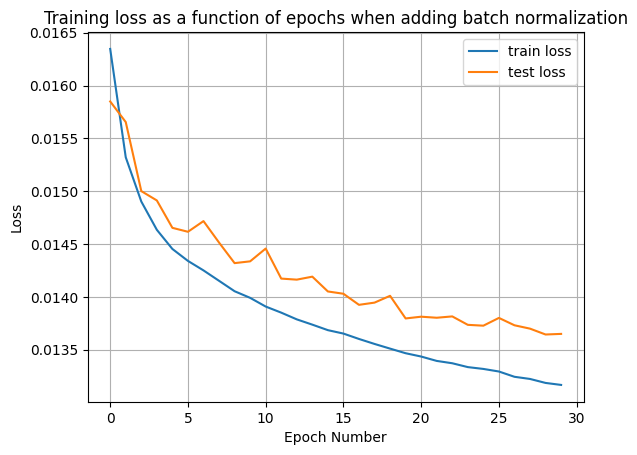

In [5]:
plt.plot(train_losses_batch)
plt.plot(test_losses_batch)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()
plt.title('Training loss as a function of epochs when adding batch normalization')
plt.legend(['train loss', 'test loss'])

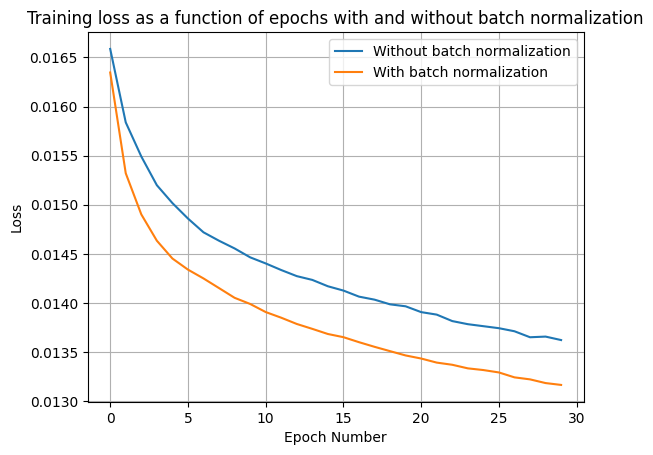

In [9]:
plt.plot(train_losses)
plt.plot(train_losses_batch)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()
plt.title('Training loss as a function of epochs with and without batch normalization')
plt.legend(['Without batch normalization', 'With batch normalization'])

- Compare the training loss with and without batch normalization as a function of epochs.

As we can see on the above graph, the plot of the training loss for the model with batch normalization shows a faster decrease compared to the plot of the training loss for the model without batch normalization. This suggests that the model converges to a smaller loss faster during training when using batch normalization than without using it, i.e. using batch normalization makes the model faster and leads to a more stable learning process during training.

- What is the final test accuracy?

The final test accuracy is 74%.


torch.Size([32, 3, 7, 7])


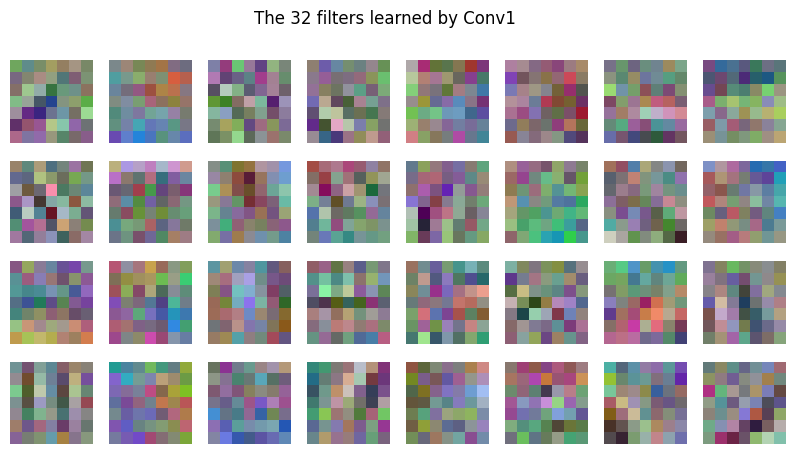

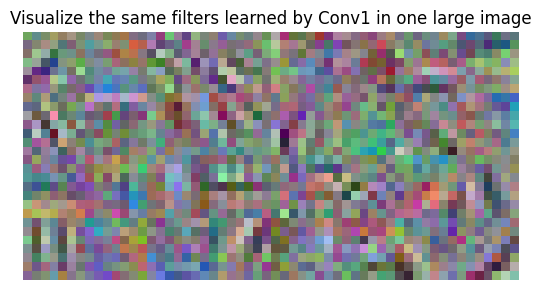

In [10]:
#retrieve filters from conv1
filters = model_batch.conv1.weight.data
print(filters.shape)
num_filters, filter_size = filters.size(0), filters.size(2)

#normalize filters
eps = 0.0001
filter_dist = torch.norm(filters, p=float('inf')) #torch.linalg.norm(filters, ord = 'inf') #max(sum(abs(filters), dim=1))
filters_norm = (filters / (2 * filter_dist + eps)) + (1/2)
filters_arr = np.transpose(filters_norm.cpu(), (0, 2, 3, 1))

#create large empty image array to display filters
num_cols, num_rows = 8, 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))
fig.suptitle('The 32 filters learned by Conv1')
for i in range(num_filters):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(filters_arr[i])
    axs[row, col].axis('off')
plt.show()

image = np.zeros((num_rows * filter_size, num_cols * filter_size, 3))
#fill image array with normalized filters
for i in range(num_filters):
    row = i // num_cols
    col = i % num_cols
    image[row * filter_size: (row + 1) * filter_size, col * filter_size: (col + 1) * filter_size, :] = filters_arr[i].cpu()

#display image of filters
plt.imshow(image)
plt.axis('off')
plt.title('Visualize the same filters learned by Conv1 in one large image')
plt.show()

### Part 3


Can you do better with a deeper and better network architecture? Optimize your CNN’s architecture to improve performance. You may get significantly better results by using smaller filters for the first convolutional layer.

Describe your model’s architecture and your design choices. What is your final accuracy?

In [ ]:
class Net_improved(nn.Module):
    def __init__(self):
        super(Net_improved, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(self.relu((self.batchnorm1(self.conv1(x)))))
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.relu(self.batchnorm4(self.conv4(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.functional.softmax(x, dim=1)
        return x

In [ ]:
#reused code from MNIST Tutorial
def train_imp(epoch):
    model_improved.train()
    train_losses = []
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.cuda(), target.cuda()
        optimizer_imp.zero_grad()
        output = model_improved(data)
        loss = loss_fn_imp(output, target) #nn.functional.nll_loss(output, target)
        loss.backward()
        torch.cuda.empty_cache() #release gpu memory
        optimizer_imp.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item())
                )
        train_losses.append(loss.item() / batch_size)
    return train_losses

def test_imp():
    model_improved.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        output = model_improved(data)
        test_loss += loss_fn_imp(output, target).sum() 
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).long().cpu().sum()
    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, 
        len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return test_loss

model_improved = Net_improved()
model_improved.cuda()
optimizer_imp = torch.optim.AdamW(model_improved.parameters(), lr=0.001, weight_decay=0.001)
loss_fn_imp = nn.CrossEntropyLoss()

train_losses_imp, test_losses_imp = [], []
num_epochs_imp = 30
print(f'Training for {num_epochs_imp} epochs')
for epoch in range(1, num_epochs_imp + 1): 
    #train and compute train loss
    epoch_train_losses_imp = train_imp(epoch)
    train_losses_imp.append(torch.tensor(epoch_train_losses_imp).mean().item())
    test_loss_imp = test_imp()
    test_losses_imp.append(test_loss_imp.item())

Training for 30 epochs
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304370
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.097861
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.021601
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.935086

Test set: Average loss: 0.0153, Accuracy: 5330/10000 (53%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.896930
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.917664
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.907118
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.834622

Test set: Average loss: 0.0150, Accuracy: 5730/10000 (57%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.815054
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.845529
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.798240
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.816018

Test set: Average loss: 0.0147, Accuracy: 6133/10000 (61%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.759688
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.788729
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.766694
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.826220

Test set: Ave

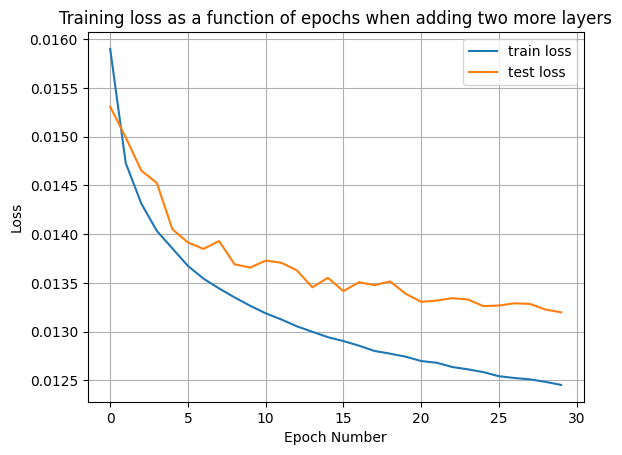

In [ ]:
plt.plot(train_losses_imp)
plt.plot(test_losses_imp)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()
plt.title('Training loss as a function of epochs when adding two more layers')
plt.legend(['train loss', 'test loss'])

- Describe your model’s architecture and your design choices. 

In this revised architecture, I kept the same architecture as the one in Part 2 but made multiple changes to increase the performance of the model. 
First, as suggested, I have decreased the filter size from 7x7 to 3x3 for the first convolutional layer as smaller filters can be more effective to capture details in the input images (this allows a better feature extraction). I also added an additional convolutional layer (conv4) as suggested to increase the depth of the architecture which can result in better feature extraction and representation.
Moreover, I decided to make conv4 output a larger number of filters (128 to be precise) as it will allow the model to capture more complex features from the input images. Finally, I updated the input size of the fully connected layer (fc) to match the output size of conv4, and I have made sure that the size of the BatchNorm2d (batch normalization) layer matches the number of channels outputed by their corresponding convolutional layers.

Overall, the architecture of this neural network consists of 4 convolutional layers (self.conv1, self.conv2, self.conv3 and self.conv4). conv1 outputs 32 convolutional filters of size 3x3. conv2 and conv3 outputs 64 filters of size 3x3, whereas conv4 outputs 124 filters of size 3x3. Batch Normalization and the ReLU activation function are applied to each of these convolutional layers. conv1 is followed by a max pooling layer (self.pool). Conv3 is followed by an adaptive average pooling layer 'self.avgpool' (to reduce the spatial dimension to 1x1), and a fully connected layer (self.fc). The fully connected layer is followed by the softmax activation function for multi-class classification.

- What is your final accuracy?

My final accuracy is: 79%.